<h1>Appendix C: TimeSeriesKMean on single sensor data

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

In [2]:
import matplotlib
import matplotlib.pyplot as plt 

In [4]:
from tslearn.clustering import TimeSeriesKMeans
#tslearn requires numpy 1.22
#pip install --upgrade threadpoolctl --user

In [5]:
# Read the CSV data into a Pandas DataFrame, please update the path according to your local storage path
df = pd.read_csv('D:\\Download\\Tool_Sensor_Data.csv')
print(df.shape)
df.head()

(14844, 90)


,TimeStamp,ToolName,TOOL_ID,Run,RunStartTime,DATA_QUALITY,EQPType,HasComments,LOT_ID,LogicalRecipeID,...,yqScxEFPLde,jrsnDLYHnMHD,CalcStepSeq,CalcLoopSeq,RunTag,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88,Unnamed: 89
0,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,...,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
3,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,...,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,...,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# All data cleaning in one Cell
# Remove Duplicated Rows, the timeline helps to ensure duplicated rows would not be removed wrongly
print('Before = ', df.shape)
df = df.drop_duplicates()
print('After = ', df.shape)
# The TimeStamp indicates it is time series data, but since it is not a sales transaction, it may not be useful.
# The more important info is the Run number for identifying which Wafer Run is good or abnormal.
if 'TimeStamp' in df.columns:
    df = df.drop('TimeStamp', axis=1)
if 'RunStartTime' in df.columns:
    df = df.drop('RunStartTime', axis=1)
# Find/Check for any other non-integer columns
for column in df.columns:
    if df[column].dtypes == 'object':
        print('column name =',column, 'type =', df[column].dtypes, 'content =', df[column].iloc[0])
# Verify manually if those columns are not useful (no value for ML), drop it
for column in df.columns:
    if df[column].dtypes == 'object':
        print(column, df[column].dtypes, '= DROP')
        df = df.drop(column, axis=1)
# Calculate how many cells inside a row is filled with data
non_empty_columns_per_row = df.count(axis=1)
non_empty_columns_per_row
# Pick a cut off threshold, in this case, based on the chart above, we can pick the centre point
print('Total length = ', len(df.columns))
threshold = len(df.columns)/2
print('Threshold =', threshold)
# Remove empty rows below the threshold
print('Before remove=',df.shape)
df = df.dropna(thresh=threshold)
print('After remove=',df.shape)
# Fill in empty cells with Zero? Number zero allows calculation of standard deviation
df = df.fillna(0)
df.head()
# Remove Useless Columns by using standard deviation check, likely those columns are zeros/emtpy or having same value.
column_stddev = {}
for column in df.columns:
    std_deviation = df[column].std()
    if std_deviation == 0:
        print(column, std_deviation, "= DROP")
        df = df.drop(column, axis=1)
    else:
        column_stddev[column]=std_deviation
# Save a copy of the clean dataframe
df_clean=df.copy()
df.to_csv('d:\\download\\1.3_Cleaning.csv', index=False)

Before =  (14844, 90)
After =  (14113, 90)
column name = ToolName type = object content = A
column name = TOOL_ID type = object content = A
column name = EQPType type = object content = A
column name = LOT_ID type = object content = A
column name = LogicalRecipeID type = object content = A
column name = LotPurposeType type = object content = Process Lot
column name = LotType type = object content = Production
column name = MachineRecipeID type = object content = A
column name = PhysicalRecipeID type = object content = A
column name = PortID type = object content = A
column name = ProcessOpNum type = object content = A
column name = ProductGrpID type = object content = A
column name = ProductID type = object content = A
column name = RECIPE_ID type = object content = A
column name = RouteID type = object content = A
column name = Technology type = object content = A
column name = EventType type = object content = StartOfRun
column name = EventName type = object content = WaferStart
colu

In [7]:
# Get unique run numbers 
runs = df['Run'].unique()
print('Total Unique Runs=',len(runs))
#runs

df_run = pd.DataFrame()
i=0
# Calculate each Run's lenght and record inside df_run
for run in runs:
    count = (df['Run'] == run).sum()
    df_run.loc[i, 'Run'] = run
    df_run.loc[i, 'Count'] = count
    i=i+1
df_run.head()
# SwpYipezsdueC - Remove all columns except SwpYipezsdueC and Run column
df_check=df
check_column = 'SwpYipezsdueC'
for column in df.columns:
    if column != check_column and column != 'Run':
        df_check=df_check.drop(column, axis=1)
print(df.shape)
# Split data into dicts by run number
data_by_run = {run: df[df['Run'] == run] for run in runs}
df.head()
# SwpYipezsdueC - Get the max lenght for resampling
i=0
mydict={}
for run, df1 in data_by_run.items():
    i = i + 1
    mylist = df1[check_column].tolist()
    mydict[run]=len(mylist)
max_key = max(mydict, key=lambda key: mydict[key])
max_value = mydict[max_key]
print('Maximum Run record lenght =', max_value)
# SwpYipezsdueC - Convert column to rows and Resample the time series and put into new dataframe
new_df = pd.DataFrame()
i=0
for run, df1 in data_by_run.items():
    i = i + 1
    mylist = df1[check_column].tolist()
    # Resample mylist using linear interpolation to match the length of the longer list
    if len(mylist) < max_value:
        x1 = np.arange(len(mylist))
        x2 = np.linspace(0, len(mylist) - 1, max_value)
        mylist = np.interp(x2, x1, mylist)
    mylist = np.insert(mylist, 0, run)
    new_row = pd.DataFrame([mylist])
    new_df = pd.concat([new_df, new_row], ignore_index=True)
new_df.set_index(0, inplace=True)
print(new_df.shape)
new_df.head()

Total Unique Runs= 228
(13657, 41)
Maximum Run record lenght = 87
(228, 87)


,1,2,3,4,5,6,7,8,9,10,...,78,79,80,81,82,83,84,85,86,87
0,,,,,,,,,,,,,,,,,,,,,
62301.0,125.0,123.697674,123.0,123.00000,123.000000,123.000000,123.000000,123.558140,124.000000,124.000000,...,139.000000,139.000000,139.000000,138.906977,138.255814,138.000000,137.953488,137.302326,137.00000,137.0
62302.0,120.0,120.000000,120.0,120.00000,120.000000,119.395349,119.000000,119.046512,119.767442,120.000000,...,139.000000,138.767442,138.046512,138.000000,138.000000,138.000000,138.000000,138.000000,137.44186,136.0
62303.0,121.0,121.000000,121.0,121.00000,121.000000,121.197674,121.837209,122.000000,122.116279,122.755814,...,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,138.837209,137.558140,137.00000,137.0
62304.0,123.0,123.000000,123.0,123.00000,123.000000,123.000000,123.488372,124.000000,124.000000,124.000000,...,138.232558,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.00000,138.0
62305.0,120.0,120.000000,120.0,119.94186,119.255814,119.000000,119.116279,119.802326,120.000000,120.000000,...,139.825581,140.000000,139.802326,139.116279,139.000000,138.744186,138.058140,138.000000,138.00000,138.0


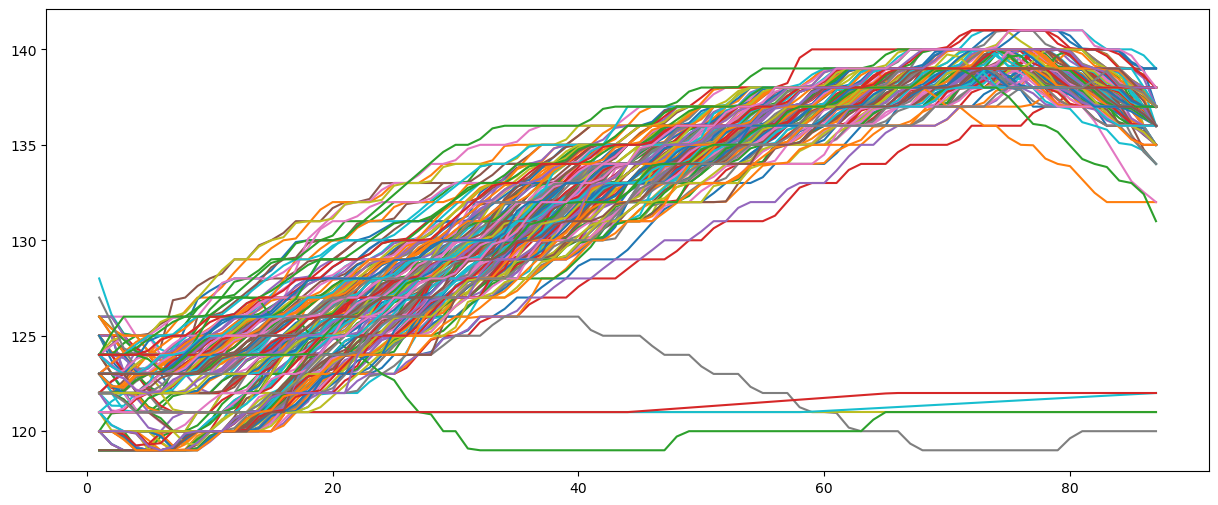

In [8]:
plt.figure(figsize=(15, 6))
for index, row in new_df.iterrows():
    plt.plot(row, label=f'Line {index}')  # Plot each row with a label
plt.show()

<H2>Based on the pattern above, there are 4 lines which is out of normal pattern.

<h1>KMean Clustering

In [9]:
import numpy
import matplotlib.pyplot as plt

from tslearn.clustering import KShape
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

import pandas as pd
from sklearn.model_selection import train_test_split

In [10]:
# Load the dataset
#X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")

# Split the data into features (X) and labels (y)
#X = df.drop('y_column_name', axis=1)  # Replace 'y_column_name' with the actual column name of your labels
#y = df['y_column_name']
#y = new_df.iloc[0]
#y = y.to_numpy().flatten()
#print(y)
#X = list(range(1, len(y) + 1))
#X = np.arange(1, len(y) + 1)
#X
# above wrong. 
y = new_df.index
y = y.astype(int)
y

#X = np.arange(1, len(y) + 1)
index_variable = new_df.index
index_variable = index_variable.astype(int)
X_df = new_df.reset_index(drop=True)
X = X_df.values
y = np.arange(1, len(X) + 1)
#print(y)
#X
print(X.shape)
print(y.shape)

(228, 87)
(228,)


In [14]:
# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#print(X_train.shape)
#print(X_train)
#print(y_train.shape)
#print(y_train)

In [15]:
#X_train = X_train[y_train < 4]
#print(X_train.shape)
#X_train

In [16]:
#X_train = X_train[:50]
#X_train

In [18]:
#numpy.random.shuffle(X_train)
#print(X_train.shape)
#print(y_train.shape)

In [19]:
# For this method to operate properly, prior scaling is required
X_train = X
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
sz = X_train.shape[1]

<h2>KShape Clustering

0.005 --> 0.005 --> 
[1 0 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0
 1 1 1 1 0 0 2 0 1 0 1 0 0 0 0 0 0 0 0 0 0 2 1 0 0 0 0 1 1 1 0 1 1 0 0 1 0
 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1 0
 0 1 0 0 1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1
 0 0 1 1 1 1]


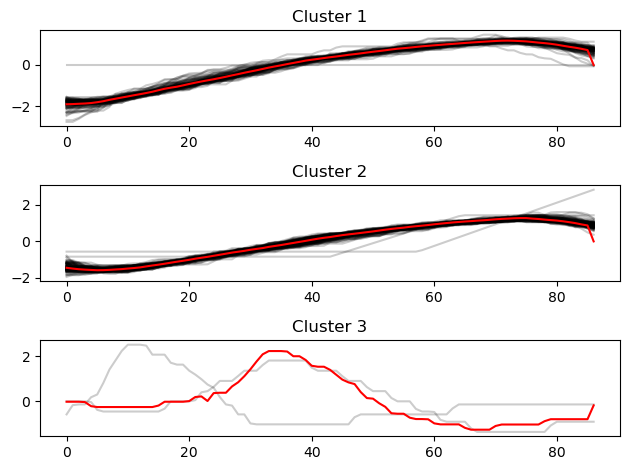

In [21]:
#X_train = X_train[y_train < 4]
#X_train = X_train[:50]
#numpy.random.shuffle(X_train)
# For this method to operate properly, prior scaling is required
#X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
#sz = X_train.shape[1]

# kShape clustering
seed = 0
numpy.random.seed(seed)
ks = KShape(n_clusters=3, verbose=True, random_state=seed)
y_pred = ks.fit_predict(X_train)
print(y_pred)

plt.figure()
for yi in range(3):
    plt.subplot(3, 1, 1 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    #plt.xlim(0, sz)
    #plt.ylim(-4, 4)
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

In [22]:
print('X_train')
print(X_train)
print('y_pred')
print(y_pred)

X_train
[[[-1.34464998]
  [-1.58249252]
  [-1.70990816]
  ...
  [ 0.90211251]
  [ 0.84689907]
  [ 0.84689907]]

 [[-1.61992522]
  [-1.61992522]
  [-1.61992522]
  ...
  [ 0.89738317]
  [ 0.8193271 ]
  [ 0.61768224]]

 [[-1.79545174]
  [-1.79545174]
  [-1.79545174]
  ...
  [ 0.89863921]
  [ 0.80782715]
  [ 0.80782715]]

 ...

 [[-1.55746254]
  [-1.55746254]
  [-1.55746254]
  ...
  [ 0.98059225]
  [ 0.91102763]
  [ 0.79930262]]

 [[-1.59519967]
  [-1.59519967]
  [-1.59519967]
  ...
  [ 1.02032427]
  [ 0.90306542]
  [ 0.78580656]]

 [[-1.38152918]
  [-1.38152918]
  [-1.452847  ]
  ...
  [ 1.20092642]
  [ 1.15588359]
  [ 1.03952294]]]
y_pred
[1 0 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0
 1 1 1 1 0 0 2 0 1 0 1 0 0 0 0 0 0 0 0 0 0 2 1 0 0 0 0 1 1 1 0 1 1 0 0 1 0
 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 0 1 0 1 1 

In [23]:
X_train_df = pd.DataFrame(X_train[:, 0, 0])  # Assuming X_train is a 3D array
y_pred_df = pd.DataFrame(y_pred, columns=['y_pred'])
#merged_df = pd.concat([X_train_df, y_pred_df], axis=1)
merged_df = pd.concat([X_df, y_pred_df], axis=1)
merged_df = merged_df.set_index(index_variable)
merged_df

,1,2,3,4,5,6,7,8,9,10,...,79,80,81,82,83,84,85,86,87,y_pred
0,,,,,,,,,,,,,,,,,,,,,
62301,125.0,123.697674,123.00000,123.000000,123.000000,123.000000,123.000000,123.558140,124.000000,124.000000,...,139.000000,139.000000,138.906977,138.255814,138.000000,137.953488,137.302326,137.000000,137.0,1
62302,120.0,120.000000,120.00000,120.000000,120.000000,119.395349,119.000000,119.046512,119.767442,120.000000,...,138.767442,138.046512,138.000000,138.000000,138.000000,138.000000,138.000000,137.441860,136.0,0
62303,121.0,121.000000,121.00000,121.000000,121.000000,121.197674,121.837209,122.000000,122.116279,122.755814,...,139.000000,139.000000,139.000000,139.000000,139.000000,138.837209,137.558140,137.000000,137.0,1
62304,123.0,123.000000,123.00000,123.000000,123.000000,123.000000,123.488372,124.000000,124.000000,124.000000,...,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.0,1
62305,120.0,120.000000,120.00000,119.941860,119.255814,119.000000,119.116279,119.802326,120.000000,120.000000,...,140.000000,139.802326,139.116279,139.000000,138.744186,138.058140,138.000000,138.000000,138.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62596,124.0,124.000000,124.00000,124.000000,124.232558,124.790698,125.000000,125.000000,125.465116,126.000000,...,138.465116,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.0,0
62597,120.0,120.000000,120.00000,119.906977,119.209302,119.000000,119.186047,119.883721,120.000000,120.000000,...,140.000000,139.883721,139.186047,139.000000,138.790698,138.093023,138.000000,138.000000,138.0,1
62598,123.0,123.000000,123.00000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.546512,...,138.930233,138.313953,138.000000,138.000000,137.465116,137.000000,137.000000,136.616279,136.0,1


In [24]:
df=merged_df
print('0',(df['y_pred'] == 0).sum())
print('1',(df['y_pred'] == 1).sum())
print('2',(df['y_pred'] == 2).sum())
print('3',(df['y_pred'] == 3).sum())

0 84
1 142
2 2
3 0


In [25]:
df.to_csv('d:\\download\\timeserieskmean.csv', index=False)

<h2>Conclusion: KMean KShape clustering does provide some accurate clustering but missed out a few abnormal patterns. Increasing the number of cluster up to 6 can help improve the accuracy. 

------

-----------------

<h1>TimeSeriesKMeans - DTW

In [26]:
index_variable = new_df.index
index_variable = index_variable.astype(int)
X_df = new_df.reset_index(drop=True)
X = X_df.values
y = np.arange(1, len(X) + 1)
print(X.shape)

(228, 87)


In [27]:
# For this method to operate properly, prior scaling is required
X_train = X
print(X_train.shape)

from tslearn.preprocessing import TimeSeriesResampler
# Don't scale it because the size of the pattern is important
#X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
#X_train = TimeSeriesResampler().fit_transform(X_train)
X_train_scale = X_train.copy()
sz = X_train.shape[1]
print(sz)
X_train = TimeSeriesResampler(sz=sz).fit_transform(X_train)
print(X_train.shape)
X_train

(228, 87)
87
(228, 87, 1)


array([[[125.        ],
        [123.69767442],
        [123.        ],
        ...,
        [137.30232558],
        [137.        ],
        [137.        ]],

       [[120.        ],
        [120.        ],
        [120.        ],
        ...,
        [138.        ],
        [137.44186047],
        [136.        ]],

       [[121.        ],
        [121.        ],
        [121.        ],
        ...,
        [137.55813953],
        [137.        ],
        [137.        ]],

       ...,

       [[123.        ],
        [123.        ],
        [123.        ],
        ...,
        [137.        ],
        [136.61627907],
        [136.        ]],

       [[121.        ],
        [121.        ],
        [121.        ],
        ...,
        [139.6744186 ],
        [138.8372093 ],
        [138.        ]],

       [[122.        ],
        [122.        ],
        [121.55813953],
        ...,
        [138.        ],
        [137.72093023],
        [137.        ]]])

In [28]:
n_cluster=6
model = TimeSeriesKMeans(n_clusters=n_cluster, metric="dtw", max_iter=10, random_state=0)
model.fit(X_train)
y_pred = model.predict(X_train)
print(y_pred)

[4 2 0 4 2 0 0 2 0 0 4 2 0 0 2 0 4 2 0 4 0 0 0 0 0 0 0 3 3 0 3 3 0 3 0 0 3
 4 0 2 3 3 2 3 3 2 0 3 2 0 4 0 0 3 2 0 4 2 0 3 2 3 4 2 3 0 0 3 3 2 3 3 2 0
 3 2 0 0 2 0 4 2 0 0 2 0 3 2 0 0 2 0 0 2 0 4 2 0 0 2 0 0 2 0 4 2 0 4 2 0 4
 0 4 4 0 3 0 5 1 1 0 0 4 0 3 0 0 0 4 0 0 4 5 1 2 0 3 2 0 4 2 3 4 2 0 4 2 0
 4 2 0 4 2 0 4 2 0 4 2 2 2 4 2 0 4 2 3 3 2 0 4 2 0 2 2 0 4 2 4 4 2 4 4 2 0
 0 2 0 0 2 0 4 2 0 3 2 0 4 2 0 0 2 4 4 2 0 4 2 0 0 2 0 4 2 0 2 0 0 2 0 0 2
 3 4 2 0 2 0]


In [29]:
#model.cluster_centers_[0]

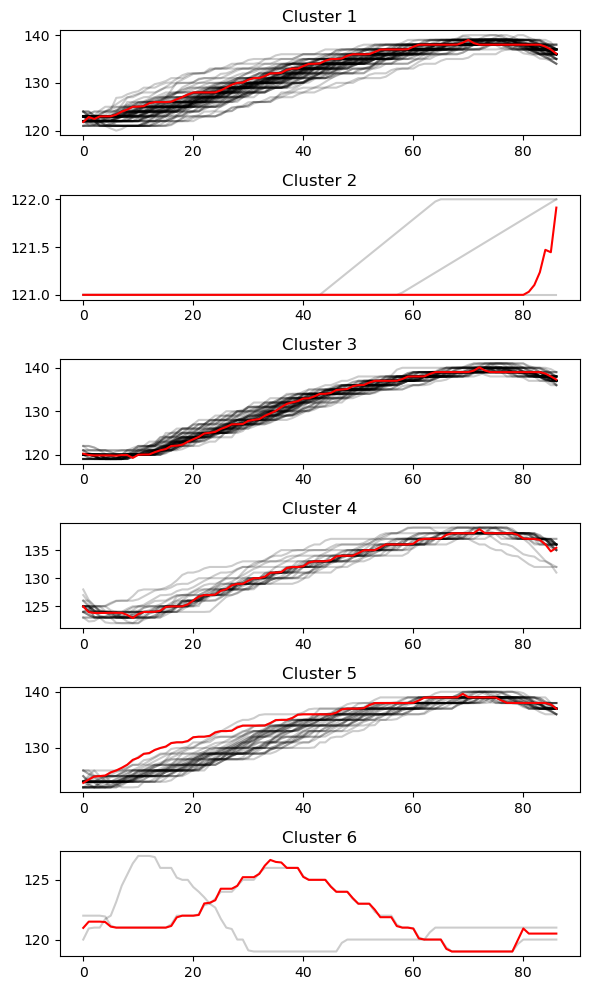

In [30]:
#plt.figure()
plt.figure(figsize=(6, 10))
for yi in range(n_cluster):
    plt.subplot(n_cluster, 1, 1 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model.cluster_centers_[yi].ravel(), "r-")
    #plt.xlim(0, sz)
    #plt.ylim(-4, 4)
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

<h2>Cluster 2 and Cluster 6 seems to identified all the abnormal patterns.

In [31]:
#X_train_df = pd.DataFrame(X_train[:, 0, 0])  # Assuming X_train is a 3D array
y_pred_df = pd.DataFrame(y_pred, columns=['y_pred'])
#merged_df = pd.concat([X_train_df, y_pred_df], axis=1)
merged_df = pd.concat([X_df, y_pred_df], axis=1)
merged_df = merged_df.set_index(index_variable)
#merged_df

In [32]:
df=merged_df
print('0',(df['y_pred'] == 0).sum())
print('1',(df['y_pred'] == 1).sum())
print('2',(df['y_pred'] == 2).sum())
print('3',(df['y_pred'] == 3).sum())
print('4',(df['y_pred'] == 4).sum())
print('5',(df['y_pred'] == 5).sum())

0 90
1 3
2 63
3 29
4 41
5 2


In [33]:
print(X_train_scale.shape)
#X_train_scale
#X_train_scale[0]
X_train_scale

(228, 87)


array([[125.        , 123.69767442, 123.        , ..., 137.30232558,
        137.        , 137.        ],
       [120.        , 120.        , 120.        , ..., 138.        ,
        137.44186047, 136.        ],
       [121.        , 121.        , 121.        , ..., 137.55813953,
        137.        , 137.        ],
       ...,
       [123.        , 123.        , 123.        , ..., 137.        ,
        136.61627907, 136.        ],
       [121.        , 121.        , 121.        , ..., 139.6744186 ,
        138.8372093 , 138.        ],
       [122.        , 122.        , 121.55813953, ..., 138.        ,
        137.72093023, 137.        ]])

In [34]:
X_train_scale2 = X_train_scale.reshape(X_train_scale.shape[0], X_train_scale.shape[1])
X_train_scale2

array([[125.        , 123.69767442, 123.        , ..., 137.30232558,
        137.        , 137.        ],
       [120.        , 120.        , 120.        , ..., 138.        ,
        137.44186047, 136.        ],
       [121.        , 121.        , 121.        , ..., 137.55813953,
        137.        , 137.        ],
       ...,
       [123.        , 123.        , 123.        , ..., 137.        ,
        136.61627907, 136.        ],
       [121.        , 121.        , 121.        , ..., 139.6744186 ,
        138.8372093 , 138.        ],
       [122.        , 122.        , 121.55813953, ..., 138.        ,
        137.72093023, 137.        ]])

In [35]:
#X_train_chart = pd.DataFrame(X_train)
X_train_chart = pd.DataFrame(X_train_scale2)
X_train_chart

,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
0,125.0,123.697674,123.00000,123.000000,123.000000,123.000000,123.000000,123.558140,124.000000,124.000000,...,139.000000,139.000000,139.000000,138.906977,138.255814,138.000000,137.953488,137.302326,137.000000,137.0
1,120.0,120.000000,120.00000,120.000000,120.000000,119.395349,119.000000,119.046512,119.767442,120.000000,...,139.000000,138.767442,138.046512,138.000000,138.000000,138.000000,138.000000,138.000000,137.441860,136.0
2,121.0,121.000000,121.00000,121.000000,121.000000,121.197674,121.837209,122.000000,122.116279,122.755814,...,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,138.837209,137.558140,137.000000,137.0
3,123.0,123.000000,123.00000,123.000000,123.000000,123.000000,123.488372,124.000000,124.000000,124.000000,...,138.232558,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.0
4,120.0,120.000000,120.00000,119.941860,119.255814,119.000000,119.116279,119.802326,120.000000,120.000000,...,139.825581,140.000000,139.802326,139.116279,139.000000,138.744186,138.058140,138.000000,138.000000,138.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,124.0,124.000000,124.00000,124.000000,124.232558,124.790698,125.000000,125.000000,125.465116,126.000000,...,139.000000,138.465116,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.0
224,120.0,120.000000,120.00000,119.906977,119.209302,119.000000,119.186047,119.883721,120.000000,120.000000,...,140.000000,140.000000,139.883721,139.186047,139.000000,138.790698,138.093023,138.000000,138.000000,138.0
225,123.0,123.000000,123.00000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.546512,...,139.000000,138.930233,138.313953,138.000000,138.000000,137.465116,137.000000,137.000000,136.616279,136.0
226,121.0,121.000000,121.00000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.534884,...,141.000000,141.000000,141.000000,141.000000,140.186047,140.000000,140.000000,139.674419,138.837209,138.0


In [36]:
merged_df_chart = X_train_chart.set_index(index_variable)
X_train_chart

,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
0,125.0,123.697674,123.00000,123.000000,123.000000,123.000000,123.000000,123.558140,124.000000,124.000000,...,139.000000,139.000000,139.000000,138.906977,138.255814,138.000000,137.953488,137.302326,137.000000,137.0
1,120.0,120.000000,120.00000,120.000000,120.000000,119.395349,119.000000,119.046512,119.767442,120.000000,...,139.000000,138.767442,138.046512,138.000000,138.000000,138.000000,138.000000,138.000000,137.441860,136.0
2,121.0,121.000000,121.00000,121.000000,121.000000,121.197674,121.837209,122.000000,122.116279,122.755814,...,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,138.837209,137.558140,137.000000,137.0
3,123.0,123.000000,123.00000,123.000000,123.000000,123.000000,123.488372,124.000000,124.000000,124.000000,...,138.232558,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.0
4,120.0,120.000000,120.00000,119.941860,119.255814,119.000000,119.116279,119.802326,120.000000,120.000000,...,139.825581,140.000000,139.802326,139.116279,139.000000,138.744186,138.058140,138.000000,138.000000,138.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,124.0,124.000000,124.00000,124.000000,124.232558,124.790698,125.000000,125.000000,125.465116,126.000000,...,139.000000,138.465116,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.0
224,120.0,120.000000,120.00000,119.906977,119.209302,119.000000,119.186047,119.883721,120.000000,120.000000,...,140.000000,140.000000,139.883721,139.186047,139.000000,138.790698,138.093023,138.000000,138.000000,138.0
225,123.0,123.000000,123.00000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.546512,...,139.000000,138.930233,138.313953,138.000000,138.000000,137.465116,137.000000,137.000000,136.616279,136.0
226,121.0,121.000000,121.00000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.534884,...,141.000000,141.000000,141.000000,141.000000,140.186047,140.000000,140.000000,139.674419,138.837209,138.0


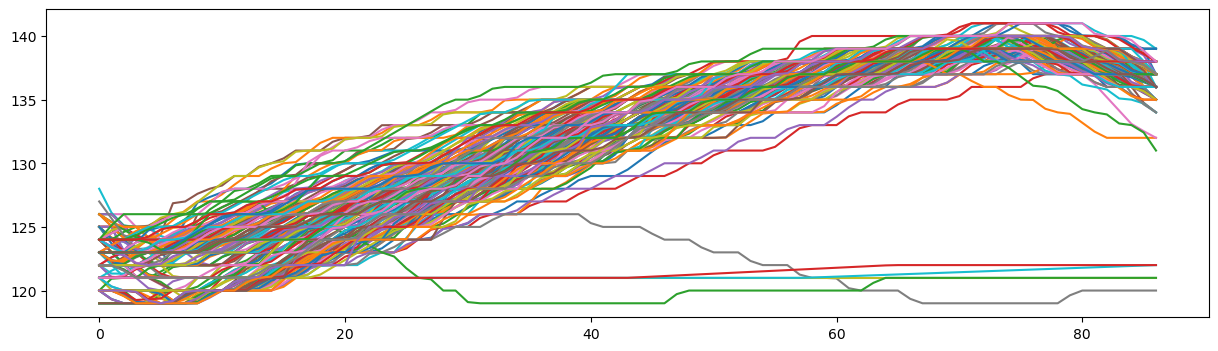

,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
0,,,,,,,,,,,,,,,,,,,,,
62301,125.0,123.697674,123.00000,123.000000,123.000000,123.000000,123.000000,123.558140,124.000000,124.000000,...,139.000000,139.000000,139.000000,138.906977,138.255814,138.000000,137.953488,137.302326,137.000000,137.0
62302,120.0,120.000000,120.00000,120.000000,120.000000,119.395349,119.000000,119.046512,119.767442,120.000000,...,139.000000,138.767442,138.046512,138.000000,138.000000,138.000000,138.000000,138.000000,137.441860,136.0
62303,121.0,121.000000,121.00000,121.000000,121.000000,121.197674,121.837209,122.000000,122.116279,122.755814,...,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,138.837209,137.558140,137.000000,137.0
62304,123.0,123.000000,123.00000,123.000000,123.000000,123.000000,123.488372,124.000000,124.000000,124.000000,...,138.232558,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.0
62305,120.0,120.000000,120.00000,119.941860,119.255814,119.000000,119.116279,119.802326,120.000000,120.000000,...,139.825581,140.000000,139.802326,139.116279,139.000000,138.744186,138.058140,138.000000,138.000000,138.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62596,124.0,124.000000,124.00000,124.000000,124.232558,124.790698,125.000000,125.000000,125.465116,126.000000,...,139.000000,138.465116,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.0
62597,120.0,120.000000,120.00000,119.906977,119.209302,119.000000,119.186047,119.883721,120.000000,120.000000,...,140.000000,140.000000,139.883721,139.186047,139.000000,138.790698,138.093023,138.000000,138.000000,138.0
62598,123.0,123.000000,123.00000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.546512,...,139.000000,138.930233,138.313953,138.000000,138.000000,137.465116,137.000000,137.000000,136.616279,136.0


In [38]:
plt.figure(figsize=(15, 4))
for index, row in merged_df_chart.iterrows():
    plt.plot(row, label=f'Line {index}')  # Plot each row with a label
plt.show()
merged_df_chart

In [39]:
# Optimization/Hyperparameter Tuning
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score
X_train2 = X_train.reshape(X_train.shape[0], X_train.shape[1])
print(X_train2.shape)

max_clusters = 10  # Adjust the maximum number of clusters as needed
silhouette_scores = []

for n_clusters in range(2, max_clusters + 1):
    # Create a TimeSeriesKMeans model with the current number of clusters
    model = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=0)
    
    # Fit the model to your time series data
    model.fit(X_train2)
    
    # Predict cluster labels for your data
    cluster_labels = model.predict(X_train2)
    
    # Calculate the silhouette score for the current number of clusters
    silhouette = silhouette_score(X_train2, cluster_labels)
    
    silhouette_scores.append(silhouette)
silhouette_scores

(228, 87)


d:\Users\tklim\anaconda3\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 228 1-dimensional timeseries
  warnings.warn(
d:\Users\tklim\anaconda3\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 228 1-dimensional timeseries
  warnings.warn(
d:\Users\tklim\anaconda3\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 228 1-dimensional timeseries
  warnings.warn(
d:\Users\tklim\anaconda3\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 228 1-dimensional timeseries
  warnings.warn(
d:\Users\tklim\anaconda3\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 228 1-dimensional timeseries
  warnings.warn(
d:\Users\tklim\anaconda3\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these 

[0.8435585406819868,
 0.37147139080283603,
 0.3518400762253112,
 0.2951402633521269,
 0.27339617881284395,
 0.2530568447035266,
 0.24049922433566023,
 0.23991270989282823,
 0.23030860525031174]

In [40]:
print(type(silhouette_scores))
silhouette_scores

<class 'list'>


[0.8435585406819868,
 0.37147139080283603,
 0.3518400762253112,
 0.2951402633521269,
 0.27339617881284395,
 0.2530568447035266,
 0.24049922433566023,
 0.23991270989282823,
 0.23030860525031174]

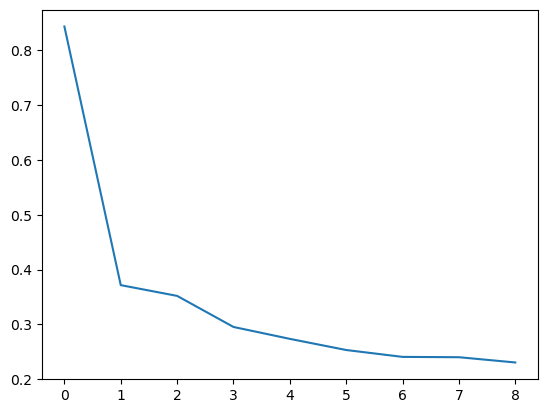

In [41]:
plt.plot(silhouette_scores)

   # plt.plot(row, label=f'Line {index}')  # Plot each row with a label
#plt.show()

<h2>Conlusion: The Elbow analysis shows the clustering is at 1 cluster but 3 and 6 is the more accurate clusting number. 

-----

In [ ]:
# Reference
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
#sklearn.metrics.silhouette_score(X, labels, *, metric='euclidean', sample_size=None, random_state=None, **kwds)

In [ ]:
# Example:
from sklearn.datasets import make_blobs
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)  # For reproducibility
print(X.shape)
X

----------

<h1>Reference sample code

In [ ]:
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [ ]:
mylist = CachedDatasets().list_datasets()
mylist

In [ ]:
data_loader = CachedDatasets()
X_train, y_train, X_test, y_test = data_loader.load_dataset("Trace")
#https://tslearn.readthedocs.io/en/stable/gen_modules/datasets/tslearn.datasets.CachedDatasets.html

In [ ]:
X_train

In [ ]:
# Author: Romain Tavenard
# License: BSD 3 clause
#https://tslearn.readthedocs.io/en/stable/auto_examples/clustering/plot_kshape.html#sphx-glr-auto-examples-clustering-plot-kshape-py
import numpy
import matplotlib.pyplot as plt

from tslearn.clustering import KShape
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

seed = 0
numpy.random.seed(seed)
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
# Keep first 3 classes and 50 first time series
X_train = X_train[y_train < 4]
X_train = X_train[:50]
numpy.random.shuffle(X_train)
# For this method to operate properly, prior scaling is required
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
sz = X_train.shape[1]

# kShape clustering
ks = KShape(n_clusters=3, verbose=True, random_state=seed)
y_pred = ks.fit_predict(X_train)

plt.figure()
for yi in range(3):
    plt.subplot(3, 1, 1 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()